In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.utils import make_grid
from PIL import Image

from tqdm import tqdm
import itertools
import shutil

from pathlib import Path

In [2]:
data_root = '/kaggle/input/gan-getting-started/'
print(data_root)
print(os.listdir(data_root))
monet_path = 'monet_jpg'
photo_path = 'photo_jpg'
BATCH_SIZE = 8

/kaggle/input/gan-getting-started/
['monet_jpg', 'photo_tfrec', 'photo_jpg', 'monet_tfrec']


5630


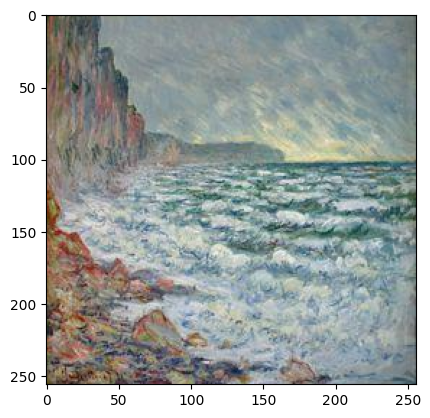

In [3]:
class MonetPhoto(Dataset):
    def __init__(self, data_root, monet_path, photo_path, transform=None):
        """
        Initialize the MonetPhoto dataset with paths to Monet and photo images and optional transformations.
        
        Args:
            data_root (str): Root directory where the data is stored.
            monet_path (str): Subdirectory within data_root containing Monet-style images.
            photo_path (str): Subdirectory within data_root containing photo images.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.data_root = data_root  # Set the root directory for data
        self.monet_path = monet_path  # Set the subdirectory for Monet images
        self.monet_images = os.listdir(os.path.join(data_root, monet_path))  # List all Monet image filenames
        self.photo_path = photo_path  # Set the subdirectory for photo images
        self.photo_images = os.listdir(os.path.join(data_root, photo_path))  # List all photo image filenames
        self.transform = transform  # Set the transformation to be applied on images

    def __len__(self):
        """
        Return the total number of samples in the dataset.
        The length is the maximum of the number of Monet and photo images to ensure pairing.
        
        Returns:
            int: Total number of samples.
        """
        return max(len(self.monet_images), len(self.photo_images))  # Ensure all images are paired

    def __getitem__(self, idx):
        """
        Retrieve a sample from the dataset at the given index.
        It pairs a Monet image with a photo image. If indices exceed the number of available images,
        it wraps around using modulo operation.
        
        Args:
            idx (int): Index of the sample to retrieve.
        
        Returns:
            tuple: A pair of Monet and photo images after applying transformations.
        """
        # Open the Monet image at the given index, wrapping around if idx exceeds length
        monet_image = Image.open(os.path.join(self.data_root, self.monet_path, self.monet_images[idx % len(self.monet_images)]))
        # Open the photo image at the given index, wrapping around if idx exceeds length
        photo_image = Image.open(os.path.join(self.data_root, self.photo_path, self.photo_images[idx % len(self.photo_images)]))
        
        # Apply transformations if any are provided
        if self.transform:
            monet_image = self.transform(monet_image)  # Transform the Monet image
            photo_image = self.transform(photo_image)  # Transform the photo image
        
        return monet_image, photo_image  # Return the transformed image pair

# Define a sequence of transformations to apply to the images
transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((256, 256)),  # Resize images to 256x256 pixels
    torchvision.transforms.ToTensor(),  # Convert PIL images to PyTorch tensors
    torchvision.transforms.Normalize(0.5, 0.5)  # Normalize tensor values to [-1, 1]
])

# Create an instance of the MonetPhoto dataset with the specified paths and transformations
dataset = MonetPhoto(data_root, monet_path, photo_path, transform=transforms)

# Get the total number of samples in the dataset
len(dataset)

# Calculate the number of samples for training (80%) and testing (20%) splits
train_size, test_size = int(len(dataset) * 0.8), len(dataset) - int(len(dataset) * 0.8)
# Split the dataset into training and testing subsets
training_data, testing_data = random_split(dataset, [train_size, test_size])

# Get the number of samples in the training subset
print(len(training_data))

# Create a DataLoader for the training data with a batch size of 16, shuffling enabled, and using 2 worker processes
train_dataloader = DataLoader(training_data.dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
# Create a DataLoader for the testing data with a batch size of 16, shuffling enabled, and using 2 worker processes
test_dataloader = DataLoader(testing_data.dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

# Retrieve the first batch of Monet and photo images from the training DataLoader
mones, photos = next(iter(train_dataloader))

# Plot the first Monet image in the batch
plt.imshow(mones[0].permute(1, 2, 0).numpy() * 0.5 + 0.5)  # Convert tensor to numpy array and denormalize for displayImage.open(os.path.join(self.data_root, self.photo_path, 


In [4]:
class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=4, stride=2, device="cuda", use_dropout=True, norm_method = 'batch'):
        """
        Initialize the CNNBlock with convolution, batch normalization, and activation layers.
        
        Args:
            in_channels (int): Number of input channels.
            out_channels (int): Number of output channels.
            stride (int, optional): Stride for the convolution. Defaults to 2.
            device (str, optional): Device to run the operations on ('cuda' or 'cpu'). Defaults to "cuda".
        """
        super().__init__()  # Initialize the parent class
        self.device = device  # Set the device
        layers = [
            nn.Conv2d(
                in_channels, 
                out_channels, 
                kernel_size=kernel_size, 
                stride=stride, 
                padding=1,
                padding_mode='reflect', 
                bias=False,
                device=self.device
            ),  # Convolutional layer with specified parameters
            nn.BatchNorm2d(out_channels, device=device) if norm_method == 'batch' else 
            nn.InstanceNorm2d(out_channels, device=device) if norm_method == 'instance' else 
            None
            ,  
            nn.LeakyReLU(0.2),  # Leaky ReLU activation with negative slope of 0.2
            ]
        self.seq = nn.Sequential(*[layer for layer in layers if layer is not None])
        self.use_dropout = use_dropout  # Set whether to use dropout
        self.dropout = nn.Dropout(0.5)  # Define a dropout layer with 50% dropout rate
    
        
    def forward(self, x):
        """
        Forward pass through the CNNBlock.
        
        Args:
            x (torch.Tensor): Input tensor.
        
        Returns:
            torch.Tensor: Output tensor after convolution, batch normalization, and activation.
        """
        x = self.seq(x)  # Apply convolution, normalization, and activation
        return self.dropout(x) if self.use_dropout else x  # Apply dropout if enabled, else return the tensor


class Discriminator(nn.Module):
    def __init__(self, in_channels=3, features=[64, 128, 256, 512], device="cuda"):
        """
        Initialize the Discriminator model using a series of CNNBlocks.
        
        Args:
            in_channels (int, optional): Number of input channels. Defaults to 3 (e.g., RGB images).
            features (list, optional): List of feature sizes for each CNNBlock. Defaults to [64, 128, 256, 512].
            device (str, optional): Device to run the operations on ('cuda' or 'cpu'). Defaults to "cuda".
        """
        super().__init__()  # Initialize the parent class
        self.device = device  # Set the device
        self.initial = nn.Sequential(
            nn.Conv2d(
                in_channels, 
                features[0], 
                kernel_size=4, 
                stride=2, 
                padding=1, 
                padding_mode='reflect', 
                device=self.device
            ),  # Initial convolutional layer
            nn.LeakyReLU(0.2)  # Leaky ReLU activation
        )
        
        layers = []  # Initialize a list to hold subsequent CNNBlocks
        in_channels = features[0]  # Set the initial number of input channels
        for feature in features[1:]:
            layers.append(
                CNNBlock(in_channels, feature, kernel_size=4, stride=1 if feature == features[-1] else 2, device=self.device, use_dropout=True),
            )  # Append CNNBlock with appropriate stride
            in_channels = feature  # Update the number of input channels for the next block
        
        layers.append(
            nn.Conv2d(
                in_channels, 
                1, 
                kernel_size=4, 
                stride=2, 
                padding=1, 
                padding_mode='reflect', 
                device=self.device
            )
        )  # Final convolutional layer to produce a single output channel (real/fake classification)
        
        self.model = nn.Sequential(*layers)  # Combine all layers into a sequential model

        def weights_init_normal(m):
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0.0, std=0.02)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0.0)
                    
        self.apply(weights_init_normal)
        
    def forward(self, x):
        """
        Forward pass through the Discriminator.
        
        Args:
            x (torch.Tensor): Input tensor (e.g., an image).
        
        Returns:
            torch.Tensor: Output tensor representing the discriminator's prediction.
        """
        x = self.initial(x)  # Apply the initial convolution and activation
        return self.model(x)  # Apply the subsequent CNNBlocks and final convolution
        

class Interpolate(nn.Module):
    def __init__(self, scale_factor=None, mode='linear'):
        """
        Initializes the Interpolate module.

        Args:
            size (int or tuple, optional): The output size. Can be a single integer or a tuple of integers.
            scale_factor (float or tuple, optional): The multiplier for spatial size. Can be a single float or a tuple of floats.
            mode (str, optional): The upsampling mode to use. Options include 'nearest', 'linear', 'bilinear', 'bicubic', and 'trilinear'.
            align_corners (bool, optional): Geometrically, if True, the corner pixels of the input and output tensors are aligned.
        """
        super(Interpolate, self).__init__()
        self.scale_factor = scale_factor
        self.mode = mode

    def forward(self, x):
        """
        Forward pass for the Interpolate module.

        Args:
            x (torch.Tensor): Input tensor.

        Returns:
            torch.Tensor: Interpolated output tensor.
        """
        if x.dim() == 4:  # 4D tensor
            n, c, h, w = x.shape
        elif x.dim() == 3:  # 3D tensor
            c, h, w = x.shape
            n = 1  # Default batch size for 3D tensor
        else:
            raise ValueError(f"Unexpected tensor shape: {x.shape}")
            
        return F.interpolate(x.view(n, c, h, w), scale_factor=self.scale_factor, mode=self.mode)


class ResizeConv(nn.Module):
    def __init__(self, in_channels, out_channels, scale_factor, kernel_size, stride, padding, device):
        super(ResizeConv, self).__init__()
        self.scale_factor = scale_factor
        self.conv = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding, device=device, bias=False)
        self.interpolate = Interpolate(scale_factor=[self.scale_factor, self.scale_factor], mode='bilinear')

    def forward(self, x):
        x = self.conv(self.interpolate(x))
        return x
        
        
class Block(nn.Module):
    def __init__(self, in_channels, out_channels, down=True, act='relu', use_dropout=False, device="cuda"):
        """
        Initialize a Block, which can act as either a downsampling or upsampling layer.
        
        Args:
            in_channels (int): Number of input channels.
            out_channels (int): Number of output channels.
            down (bool, optional): If True, performs downsampling using Conv2d; else, upsampling using ConvTranspose2d. Defaults to True.
            act (str, optional): Activation function to use ('relu' or 'leaky'). Defaults to 'relu'.
            use_dropout (bool, optional): Whether to include a dropout layer. Defaults to False.
            device (str, optional): Device to run the operations on ('cuda' or 'cpu'). Defaults to "cuda".
        """
        super().__init__()  # Initialize the parent class
        self.device = device  # Set the device
        self.seq = nn.Sequential(
            nn.Conv2d(
                in_channels, 
                out_channels, 
                kernel_size=4, 
                stride=2, 
                padding=1,
                bias=False,
                padding_mode='reflect', 
                device=self.device
            ) if down else ResizeConv(
                in_channels, 
                out_channels,
                scale_factor=2.0,
                kernel_size=3, 
                stride=1, 
                padding=1,
                device=self.device
            ),  # Choose Conv2d for downsampling or ConvTranspose2d for upsampling
            nn.InstanceNorm2d(out_channels, device=self.device),  # Batch normalization
            nn.ReLU() if act == 'relu' else nn.LeakyReLU(0.2),  # Activation function
        )
        self.use_dropout = use_dropout  # Set whether to use dropout
        self.dropout = nn.Dropout(0.5)  # Define a dropout layer with 50% dropout rate
    
    def forward(self, x):
        """
        Forward pass through the Block.
        
        Args:
            x (torch.Tensor): Input tensor.
        
        Returns:
            torch.Tensor: Output tensor after convolution, normalization, activation, and optional dropout.
        """
        x = self.seq(x)  # Apply convolution, normalization, and activation
        return self.dropout(x) if self.use_dropout else x  # Apply dropout if enabled, else return the tensor


class Generator(nn.Module):
    def __init__(self, in_channels=3, features=64, device="cuda"):
        """
        Initialize the Generator model using a series of downsampling and upsampling Blocks.
        
        Args:
            in_channels (int, optional): Number of input channels. Defaults to 3 (e.g., RGB images).
            features (int, optional): Base number of feature channels. Defaults to 64.
            device (str, optional): Device to run the operations on ('cuda' or 'cpu'). Defaults to "cuda".
        """
        super().__init__()  # Initialize the parent class
        self.device = device  # Set the device
        self.initial_down = nn.Sequential(
            nn.Conv2d(
                in_channels, 
                features, 
                kernel_size=4, 
                stride=2, 
                padding=1, 
                padding_mode='reflect', 
                device=self.device
            ),  # Initial convolutional layer
            nn.LeakyReLU(0.2),  # Leaky ReLU activation
        )  # Output size: 128
        
        # Define downsampling Blocks
        self.down1 = Block(features, features*2, down=True, act='leaky', use_dropout=False)   # Output size: 64
        self.down2 = Block(features*2, features*4, down=True, act='leaky', use_dropout=False) # Output size: 32
        self.down3 = Block(features*4, features*8, down=True, act='leaky', use_dropout=False) # Output size: 16
        self.down4 = Block(features*8, features*8, down=True, act='leaky', use_dropout=False) # Output size: 8
        self.down5 = Block(features*8, features*8, down=True, act='leaky', use_dropout=False) # Output size: 4
        self.down6 = Block(features*8, features*8, down=True, act='leaky', use_dropout=False) # Output size: 2
        
        # Bottleneck layer
        self.bottleneck = nn.Sequential(
            nn.Conv2d(
                features*8, 
                features*8, 
                kernel_size=4, 
                stride=2, 
                padding=1, 
                padding_mode='reflect', 
                device=self.device
            ),  # Convolutional layer at the bottleneck
            nn.ReLU(),  # ReLU activation
        )  # Output size: 1x1
        
        # Define upsampling Blocks with skip connections
        self.up1 = Block(features*8, features*8, down=False, act='relu', use_dropout=True)  # Output size: 2
        self.up2 = Block(features*8*2, features*8, down=False, act='relu', use_dropout=True)  # Output size: 4
        self.up3 = Block(features*8*2, features*8, down=False, act='relu', use_dropout=True)  # Output size: 8
        self.up4 = Block(features*8*2, features*8, down=False, act='relu', use_dropout=False) # Output size: 16
        self.up5 = Block(features*8*2, features*4, down=False, act='relu', use_dropout=False) # Output size: 32
        self.up6 = Block(features*4*2, features*2, down=False, act='relu', use_dropout=False) # Output size: 64
        self.up7 = Block(features*2*2, features, down=False, act='relu', use_dropout=False)   # Output size: 128
        
        # Final upsampling layer to reconstruct the image
        self.finil_up = nn.Sequential(
            ResizeConv(
                features*2, 
                features, 
                scale_factor=2.0,
                kernel_size=3,
                stride=1, 
                padding=1,
                device=self.device
            ),
            CNNBlock(features, in_channels, kernel_size=3, stride=1, device=device, norm_method = 'none'),
            nn.Tanh(),  # Tanh activation to scale the output between -1 and 1
        )
        
        def weights_init_normal(m):
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0.0, std=0.02)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0.0)
                    
        self.apply(weights_init_normal)
        
    def forward(self, x):
        """
        Forward pass through the Generator, implementing the U-Net architecture with skip connections.
        
        Args:
            x (torch.Tensor): Input tensor (e.g., an image).
        
        Returns:
            torch.Tensor: Output tensor representing the generated image.
        """
        d1 = self.initial_down(x)  # Apply initial downsampling
        d2 = self.down1(d1)  # Apply first downsampling Block
        d3 = self.down2(d2)  # Apply second downsampling Block
        d4 = self.down3(d3)  # Apply third downsampling Block
        d5 = self.down4(d4)  # Apply fourth downsampling Block
        d6 = self.down5(d5)  # Apply fifth downsampling Block
        d7 = self.down6(d6)  # Apply sixth downsampling Block
        
        bottleneck = self.bottleneck(d7)  # Apply bottleneck layer
        
        up1 = self.up1(bottleneck)  # Apply first upsampling Block
        up2 = self.up2(torch.cat([up1, d7], 1))  # Concatenate with corresponding downsampled feature map and apply second upsampling Block
        up3 = self.up3(torch.cat([up2, d6], 1))  # Concatenate with corresponding downsampled feature map and apply third upsampling Block
        up4 = self.up4(torch.cat([up3, d5], 1))  # Concatenate with corresponding downsampled feature map and apply fourth upsampling Block
        up5 = self.up5(torch.cat([up4, d4], 1))  # Concatenate with corresponding downsampled feature map and apply fifth upsampling Block
        up6 = self.up6(torch.cat([up5, d3], 1))  # Concatenate with corresponding downsampled feature map and apply sixth upsampling Block
        up7 = self.up7(torch.cat([up6, d2], 1))  # Concatenate with corresponding downsampled feature map and apply seventh upsampling Block

        # Concatenate with initial downsampled feature map and apply final upsampling to generate the output image
        return self.finil_up(torch.cat([up7, d1], 1))

In [25]:
class Trainer:
    def __init__(
        self,
        train_data: DataLoader,
        val_data: DataLoader,
        target_generator: torch.nn.Module,
        target_discriminator: torch.nn.Module,
        source_generator: torch.nn.Module,
        source_discriminator: torch.nn.Module,
        nb_epochs: int = 5,
        device: str = "cuda",
        save_path: str = None,
        discriminator_workouts_per_step: int = 1,
        generator_workouts_per_step: int = 1,
        lambda_coef: int = 10,
        buffer_size: int = 64,
    ):
        """
        Initialize the Trainer with data loaders, models, training parameters, and device configuration.
        
        Args:
            train_data (DataLoader): DataLoader for training data.
            val_data (DataLoader): DataLoader for validation data.
            generator (torch.nn.Module): Generator model.
            discriminator (torch.nn.Module): Discriminator model.
            nb_epochs (int, optional): Number of training epochs. Defaults to 5.
            device (str, optional): Device to run the training on ('cuda' or 'cpu'). Defaults to "cuda".
            save_path (str, optional): Path to save the trained models. Defaults to None.
        """
        self.train_data = train_data                      # Assign training data loader
        self.val_data = val_data                          # Assign validation data loader
        self.target_generator = target_generator          # Assign generator model
        self.target_discriminator = target_discriminator  # Assign discriminator model
        self.source_generator = source_generator          # Assign generator model
        self.source_discriminator = source_discriminator  # Assign discriminator model
        self.nb_epochs = nb_epochs                        # Set number of epochs
        self.device = device                              # Set device for computation
        self.save_path = Path(save_path) if save_path else save_path  # Set save path as Path object if provided

        self.discriminator_workouts_per_step = discriminator_workouts_per_step
        self.generator_workouts_per_step = generator_workouts_per_step

        self.lambda_coef = lambda_coef

        self.EXPONENTIAL_LOSS = 0.1

        self.buffer_size = buffer_size
        self.t_buffer_images = None
        self.s_buffer_images = None

        # Initialize a fixed set of validation samples for monitoring generator progress
        self.z = next(iter(self.val_data))[0][:32].to(self.device)
        
        # Initialize a dictionary to store training logs
        self.logs = {
            "Step": [],
            "Train_tg_loss": [],
            "Train_td_loss": [],
            "Val_tg_loss": [],
            "Val_td_loss": [],
            "Train_sg_loss": [],
            "Train_sd_loss": [],
            "Val_sg_loss": [],
            "Val_sd_loss": [],
            "Samples": [],
        }

    def init_optimizers(self, lr: float=2e-4, betas: tuple=(0.5, 0.999), weight_decay: float=1e-4):
        """
        Initialize the optimizers for the generator and discriminator.
        
        Args:
            lr (float, optional): Learning rate for the optimizers. Defaults to 1e-4.
            betas (tuple, optional): Beta parameters for the AdamW optimizer. Defaults to (0.9, 0.999).
            weight_decay (float, optional): Weight Decay regularization. Defaults to 1e-4
        """
        # Initialize Adam optimizer for the generator
        self.tg_optimizer = torch.optim.AdamW(
            self.target_generator.parameters(), lr=lr, betas=betas, weight_decay=weight_decay
        )
        # Initialize Adam optimizer for the discriminator
        self.td_optimizer = torch.optim.AdamW(
            self.target_discriminator.parameters(), lr=lr, betas=betas, weight_decay=weight_decay
        )
        # Initialize Adam optimizer for the generator
        self.sg_optimizer = torch.optim.AdamW(
            self.source_generator.parameters(), lr=lr, betas=betas, weight_decay=weight_decay
        )
        # Initialize Adam optimizer for the discriminator
        self.sd_optimizer = torch.optim.AdamW(
            self.source_discriminator.parameters(), lr=lr, betas=betas, weight_decay=weight_decay
        )

    def init_buffers(self):
        with torch.no_grad():
            initial_images = []
            initial_mones = []
            for batch in self.train_data:
                X, y = batch
                initial_images.append(X)
                initial_mones.append(y)
                if len(initial_images) >= self.buffer_size:
                    break
                    
            self.t_buffer_images = self.target_generator(torch.cat(initial_images, dim=0).to(self.device)[:self.buffer_size])
            self.s_buffer_images = self.source_generator(torch.cat(initial_mones, dim=0).to(self.device)[:self.buffer_size])

    def init_epoch_logs(self):
        self.epoch_logs = {
            "Train_tg_loss": [],
            "Train_td_loss": [],
            "Val_tg_loss": [],
            "Val_td_loss": [],
            "Train_sg_loss": [],
            "Train_sd_loss": [],
            "Val_sg_loss": [],
            "Val_sd_loss": [],
        }
    
    def update_buffers(self, x, y):
        indices = torch.randint(high = self.buffer_size, size = (BATCH_SIZE,))
        self.t_buffer_images[indices] = x
        self.s_buffer_images[indices] = y

    def sample_buffers(self, size):
        indices = torch.randint(high = self.buffer_size, size = (BATCH_SIZE,))
        return self.t_buffer_images[indices], self.s_buffer_images[indices]
        

    def train(self):
        """
        Execute the training loop for the GAN, including training and validation phases,
        logging, and model checkpointing.
        
        Returns:
            dict: Dictionary containing training logs.
        """
        # Ensure that both optimizers are initialized before training
        assert (self.tg_optimizer is not None) and (
            self.td_optimizer is not None
        ) and (self.sg_optimizer is not None) and (
            self.sd_optimizer is not None
        ), "Please run Trainer().init_optimizer()"

        # If a saved model exists at the save path, load the model weights
        if self.save_path and self.save_path.exists():
            self.load_model()
            
        best_score = torch.inf  # Initialize the best validation score to infinity

        # Iterate over each epoch
        for i in range(self.nb_epochs):
            self.init_epoch_logs()
            # Initialize cumulative losses for the epoch
            train_td_loss, train_tg_loss, val_td_loss, val_tg_loss = 0, 0, 0, 0
            train_sd_loss, train_sg_loss, val_sd_loss, val_sg_loss = 0, 0, 0, 0
            train_cycle_loss, val_cycle_loss = 0, 0
            
            self.target_generator.train()      # Set generator to training mode
            self.target_discriminator.train()  # Set discriminator to training mode
            self.source_generator.train()      # Set generator to training mode
            self.source_discriminator.train()  # Set discriminator to training mode

            # Training loop with progress bar
            loop = tqdm(
                enumerate(itertools.islice(self.train_data, len(self.train_data) - 1)),  # Skip the last element
                desc=f"Epoch {i + 1}/{self.nb_epochs} training",
                leave=True,
                total=len(self.train_data) - 1,  # Update the total to reflect the adjusted length
            )
            for step, (x, y) in loop:
                x = x.to(self.device)  # Move input data to the specified device
                y = y.to(self.device)  # Move target data to the specified device

                # Perform a training step and retrieve generator and discriminator losses
                tg_loss, td_loss, sg_loss, sd_loss, cycle_loss = self.train_step(x, y)

                # Accumulate the losses with exponential averaging
                train_tg_loss = (1 - self.EXPONENTIAL_LOSS) * train_tg_loss + self.EXPONENTIAL_LOSS * tg_loss
                train_td_loss = (1 - self.EXPONENTIAL_LOSS) * train_td_loss + self.EXPONENTIAL_LOSS * td_loss
                train_sg_loss = (1 - self.EXPONENTIAL_LOSS) * train_sg_loss + self.EXPONENTIAL_LOSS * sg_loss
                train_sd_loss = (1 - self.EXPONENTIAL_LOSS) * train_sd_loss + self.EXPONENTIAL_LOSS * sd_loss
                train_cycle_loss = (1 - self.EXPONENTIAL_LOSS) * train_cycle_loss + self.EXPONENTIAL_LOSS * cycle_loss
                

                # Update the progress bar with average losses
                # Update the progress bar with average losses
                loop.set_postfix_str(
                    f"tg_loss: {train_tg_loss :.2f}, "
                    f"td_loss: {train_td_loss :.2f} :: "
                    f"sg_loss: {train_sg_loss :.2f}, "
                    f"sd_loss: {train_sd_loss :.2f} :: "
                    f"cycle_loss: {train_cycle_loss :.2f}"
                )

            # Validation phase
            self.target_generator.eval()      # Set generator to evaluation mode
            self.target_discriminator.eval()  # Set discriminator to evaluation mode
            self.source_generator.eval()      # Set generator to evaluation mode
            self.source_discriminator.eval()  # Set discriminator to evaluation mode

            # Validation loop with progress bar
            loop = tqdm(
                enumerate(self.val_data),
                desc=f"Epoch {i + 1}/{self.nb_epochs} validation",
                leave=True,
                total=len(self.val_data),
            )
            for step, (x, y) in loop:
                x = x.to(self.device)  # Move input data to the specified device
                y = y.to(self.device)  # Move target data to the specified device

                # Perform a validation step and retrieve generator and discriminator losses
                tg_loss, td_loss, sg_loss, sd_loss, cycle_loss = self.val_step(x, y)

                # Accumulate the validation losses with exponential averaging
                val_tg_loss = (1 - self.EXPONENTIAL_LOSS) * val_tg_loss + self.EXPONENTIAL_LOSS * tg_loss
                val_td_loss = (1 - self.EXPONENTIAL_LOSS) * val_td_loss + self.EXPONENTIAL_LOSS * td_loss
                val_sg_loss = (1 - self.EXPONENTIAL_LOSS) * val_sg_loss + self.EXPONENTIAL_LOSS * sg_loss
                val_sd_loss = (1 - self.EXPONENTIAL_LOSS) * val_sd_loss + self.EXPONENTIAL_LOSS * sd_loss
                val_cycle_loss = (1 - self.EXPONENTIAL_LOSS) * val_cycle_loss + self.EXPONENTIAL_LOSS * cycle_loss

                # Update the progress bar with average losses
                loop.set_postfix_str(
                    f"tg_loss: {val_tg_loss :.2f}, "
                    f"td_loss: {val_td_loss :.2f} :: "
                    f"sg_loss: {val_sg_loss :.2f}, "
                    f"sd_loss: {val_sd_loss :.2f} :: "
                    f"cycle_loss: {val_cycle_loss :.2f}"
                )

            # Check if the current validation loss is the best so far
            if self.save_path and best_score > val_tg_loss:
                best_score = val_tg_loss  # Update the best score
                self.save_model()  # Save the current model as the best model

            # Log the metrics for the current epoch
            self.log_metrics(
                step=i,
                train_tg_loss=train_tg_loss,
                train_td_loss=train_td_loss,
                val_tg_loss=val_tg_loss,
                val_td_loss=val_td_loss,
                train_sg_loss=train_sg_loss,
                train_sd_loss=train_sd_loss,
                val_sg_loss=val_sg_loss,
                val_sd_loss=val_sd_loss,
            )
            # Generate and display sample images from the generator
            fake_img = self.target_generator((photos[0].unsqueeze(0)).to('cuda'))
            cycle_img = self.source_generator(fake_img)
                
            fake_img = fake_img[0].cpu().detach()
            cycle_img = cycle_img[0].cpu().detach()
                
            # Plot the original photo and the generated fake image
            fig, ax = plt.subplots(1, 3, figsize=(20, 4))
            ax[0].imshow(photos[0].permute(1, 2, 0).numpy() * 0.5 + 0.5)
            ax[0].set_title("Photo")
            ax[0].set(xticks=[], yticks=[])
            ax[1].imshow(fake_img.permute(1, 2, 0).numpy() * 0.5 + 0.5)
            ax[1].set_title("FakeMonet")
            ax[1].set(xticks=[], yticks=[])
            ax[2].imshow(cycle_img.permute(1, 2, 0).numpy() * 0.5 + 0.5)
            ax[2].set_title("CyclePhoto")
            ax[2].set(xticks=[], yticks=[])
            plt.show()
            
        return self.logs  # Return the training logs

    def train_step(
        self,
        x: torch.Tensor,
        y: torch.Tensor
    ) -> tuple:
        """
        Perform a single training step for both generator and discriminator.
        
        Args:
            x (torch.Tensor): Input tensor (e.g., photos).
            y (torch.Tensor): Target tensor (e.g., Monet paintings).
            
        Returns:
            tuple: Generator loss and discriminator loss.
        """
        x_b, y_b = self.sample_buffers(BATCH_SIZE)
        self.update_buffers(x, y)
                    
        x = torch.cat([x, x_b], dim=0)
        y = torch.cat([y, y_b], dim=0)
        
        td_loss, tg_loss, sd_loss, sg_loss = -1, -1, -1, -1
        for _ in range(self.discriminator_workouts_per_step):
            self.td_optimizer.zero_grad(set_to_none=True)  # Reset discriminator gradients
            self.sd_optimizer.zero_grad(set_to_none=True)  # Reset discriminator gradients

            # Generate fake images and classify them with the discriminator
            # Classify real images with the discriminator
            
            tfake, treal  = self.target_discriminator(self.target_generator(x)), self.target_discriminator(y)
            sfake, sreal  = self.source_discriminator(self.source_generator(y)), self.source_discriminator(x)
            
            # Calculate discriminator loss: real images should be classified as ones and fake as zeros
            td_loss = (
                F.mse_loss(treal, torch.ones_like(treal, device=self.device)) + 
                F.mse_loss(tfake, torch.zeros_like(tfake, device=self.device))
            )
            sd_loss = (
                F.mse_loss(sreal, torch.ones_like(sreal, device=self.device)) + 
                F.mse_loss(sfake, torch.zeros_like(sfake, device=self.device))
            )
            td_loss.backward()  # Backpropagate discriminator loss
            sd_loss.backward()
            
            torch.nn.utils.clip_grad_norm_(self.target_discriminator.parameters(), max_norm=1.0) # Clip gradient
            torch.nn.utils.clip_grad_norm_(self.source_discriminator.parameters(), max_norm=1.0) # Clip gradient
            
            self.td_optimizer.step()  # Update discriminator weights
            self.sd_optimizer.step()  # Update discriminator weights

            self.epoch_log_metrics(
                train_tg_loss=tg_loss,
                train_td_loss=td_loss,
                train_sg_loss=sg_loss,
                train_sd_loss=sd_loss,
                train=True,
            )

        # Re-generate fake images for generator training
        for _ in range(self.generator_workouts_per_step):
            self.tg_optimizer.zero_grad(set_to_none=True)  # Reset generator gradients
            self.sg_optimizer.zero_grad(set_to_none=True)  # Reset generator gradients

            tfake, sfake = self.target_generator(x), self.source_generator(y)
            tcycle, scycle = self.target_generator(sfake), self.source_generator(tfake)
            tfake, sfake = self.target_discriminator(tfake), self.source_discriminator(sfake)
            
            # Calculate generator loss: including adversary and cycle loss
            tg_loss = F.mse_loss(tfake, torch.ones_like(tfake, device=self.device))
            sg_loss = F.mse_loss(sfake, torch.ones_like(sfake, device=self.device))
            cycle_loss = F.l1_loss(scycle, x) + F.l1_loss(tcycle, y)
            
            generators_loss = tg_loss + sg_loss + self.lambda_coef * cycle_loss
            generators_loss.backward()  # Backpropagate generator loss
            
            torch.nn.utils.clip_grad_norm_(self.target_generator.parameters(), max_norm=2.0) # Clip gradient
            torch.nn.utils.clip_grad_norm_(self.source_generator.parameters(), max_norm=2.0) # Clip gradient
            self.tg_optimizer.step()  # Update generator weights
            self.sg_optimizer.step()  # Update generator weights

            self.epoch_log_metrics(
                train_tg_loss=tg_loss,
                train_td_loss=td_loss,
                train_sg_loss=sg_loss,
                train_sd_loss=sd_loss,
                train=True,
            )

        return tg_loss.item(), td_loss.item(), sg_loss.item(), sd_loss.item(), cycle_loss.item()  # Return scalar losses

    @torch.no_grad()
    def val_step(
        self,
        x: torch.Tensor,
        y: torch.Tensor,
    ) -> tuple:
        """
        Perform a single validation step without updating the model.
        
        Args:
            x (torch.Tensor): Input tensor (e.g., photos).
            y (torch.Tensor): Target tensor (e.g., Monet paintings).
            
        Returns:
            tuple: Generator loss and discriminator loss.
        """
        # Generate fake images and classify them with the discriminator
        tfake = self.target_generator(x)
        sfake = self.source_generator(y)
        tcycle = self.target_generator(sfake)
        scycle = self.source_generator(tfake)
        
        # Classify real images with the discriminator
        treal = self.target_discriminator(y)
        sreal = self.source_discriminator(x)
        tfake = self.target_discriminator(tfake)
        sfake = self.source_discriminator(sfake)
        
        # Calculate generator loss: fake images should be classified as ones
        tg_loss = torch.nn.functional.mse_loss(tfake, torch.ones_like(tfake, device=self.device))
        sg_loss = torch.nn.functional.mse_loss(sfake, torch.ones_like(sfake, device=self.device))
        # Calculate discriminator loss: real images as ones and fake as zeros
        td_loss = (
            torch.nn.functional.mse_loss(treal, torch.ones_like(treal, device=self.device)) + 
            torch.nn.functional.mse_loss(tfake, torch.zeros_like(tfake, device=self.device))
        )
        sd_loss = (
            torch.nn.functional.mse_loss(sreal, torch.ones_like(sreal, device=self.device)) + 
            torch.nn.functional.mse_loss(sfake, torch.zeros_like(sfake, device=self.device))
        )
        cycle_loss = F.l1_loss(scycle, x) + F.l1_loss(tcycle, y)

        self.epoch_log_metrics(
            val_tg_loss=tg_loss.item(),
            val_td_loss=td_loss.item(),
            val_sg_loss=sg_loss.item(),
            val_sd_loss=sd_loss.item(),
            train=False,
        )
        
        return tg_loss.item(), td_loss.item(), sg_loss.item(), sd_loss.item(), cycle_loss.item()  # Return scalar losses

    @torch.no_grad() # Make this one function 
    def epoch_log_metrics(
        tg_loss: torch.Tensor,
        td_loss: torch.Tensor,
        sg_loss: torch.Tensor,
        sd_loss: torch.Tensor,
        train: bool,
    ):
        if train:
            self.epoch_logs["Train_tg_loss"].append(tg_loss)      # Log training generator loss
            self.epoch_logs["Train_td_loss"].append(td_loss)      # Log training discriminator loss
            self.epoch_logs["Train_sg_loss"].append(sg_loss)      # Log training generator loss
            self.epoch_logs["Train_sd_loss"].append(sd_loss)      # Log training discriminator loss
        else:
            self.epoch_logs["Val_tg_loss"].append(tg_loss)        # Log validation generator loss
            self.epoch_logs["Val_sg_loss"].append(sg_loss)        # Log validation generator loss
            self.epoch_logs["Val_sd_loss"].append(sd_loss)        # Log validation discriminator loss
            self.epoch_logs["Val_td_loss"].append(td_loss)        # Log validation discriminator loss

    @torch.no_grad()
    def log_metrics(
        self,
        step: int,
        train_tg_loss: torch.Tensor,
        train_td_loss: torch.Tensor,
        val_tg_loss: torch.Tensor,
        val_td_loss: torch.Tensor,
        train_sg_loss: torch.Tensor,
        train_sd_loss: torch.Tensor,
        val_sg_loss: torch.Tensor,
        val_sd_loss: torch.Tensor,
    ):
        """
        Log the training and validation metrics for the current epoch.
        
        Args:
            step (int): Current epoch number.
            train_g_loss (torch.Tensor): EMA generator loss during training.
            train_d_loss (torch.Tensor): Cumulative discriminator loss during training.
            val_g_loss (torch.Tensor): Cumulative generator loss during validation.
            val_d_loss (torch.Tensor): Cumulative discriminator loss during validation.
        """
        self.logs["Step"].append(step)  # Log the current epoch
        self.logs["Train_tg_loss"].append(train_tg_loss)    # Log average training generator loss
        self.logs["Train_td_loss"].append(train_td_loss)    # Log average training discriminator loss
        self.logs["Val_tg_loss"].append(val_tg_loss)        # Log average validation generator loss
        self.logs["Val_td_loss"].append(val_td_loss)        # Log average validation discriminator loss
        self.logs["Train_sg_loss"].append(train_sg_loss)    # Log average training generator loss
        self.logs["Train_sd_loss"].append(train_sd_loss)    # Log average training discriminator loss
        self.logs["Val_sg_loss"].append(val_sg_loss)        # Log average validation generator loss
        self.logs["Val_sd_loss"].append(val_sd_loss)        # Log average validation discriminator loss
        self.logs["Samples"].append(make_grid(self.target_generator(self.z).cpu() * 0.5 + 0.5, normalize=True))  # Log generated sample images

    def save_model(self, full: bool = False):
        """
        Save the generator and discriminator models.
        
        Args:
            full (bool, optional): Whether to save the full model or just the state dictionaries. Defaults to False.
        """
        if full:
            # Save the entire generator and discriminator models
            torch.save(self.target_generator, Path(self.save_path) / "target_generator.pth")
            torch.save(self.target_discriminator, Path(self.save_path) / "target_discriminator.pth")
            torch.save(self.source_generator, Path(self.save_path) / "source_generator.pth")
            torch.save(self.source_discriminator, Path(self.save_path) / "source_discriminator.pth")
        else:
            # Save only the state dictionaries (weights) of the models
            torch.save(
                self.target_generator.state_dict(),
                Path(self.save_path) / "target_generator_weights.pth",
            )
            torch.save(
                self.target_discriminator.state_dict(),
                Path(self.save_path) / "target_discriminator_weights.pth",
            )
            torch.save(
                self.source_generator.state_dict(),
                Path(self.save_path) / "source_generator_weights.pth",
            )
            torch.save(
                self.source_discriminator.state_dict(),
                Path(self.save_path) / "source_discriminator_weights.pth",
            )

    def load_model(self, full: bool = False):
        """
        Load the generator and discriminator models.
        
        Args:
            full (bool, optional): Whether to load the full model or just the state dictionaries. Defaults to False.
        """
        if (
            full
            and (self.save_path / "target_generator.pth").is_file()
            and (self.save_path / "target_discriminator.pth").is_file()
            and (self.save_path / "source_generator.pth").is_file()
            and (self.save_path / "source_discriminator.pth").is_file()
        ):
            # Load the entire generator and discriminator models
            self.target_generator = torch.load(self.save_path / "target_generator.pth")
            self.target_discriminator = torch.load(self.save_path / "target_discriminator.pth")
            self.source_generator = torch.load(self.save_path / "source_generator.pth")
            self.source_discriminator = torch.load(self.save_path / "source_discriminator.pth")
        elif (
            (self.save_path / "target_generator_weights.pth").is_file() and
            (self.save_path / "target_discriminator_weights.pth").is_file() and
            (self.save_path / "source_generator_weights.pth").is_file() and
            (self.save_path / "source_discriminator_weights.pth").is_file()
        ):
            # Load only the state dictionaries (weights) of the models
            self.target_generator.load_state_dict(torch.load(self.save_path / "target_generator_weights.pth"))
            self.target_discriminator.load_state_dict(torch.load(self.save_path / "target_discriminator_weights.pth"))
            self.source_generator.load_state_dict(torch.load(self.save_path / "source_generator_weights.pth"))
            self.source_discriminator.load_state_dict(torch.load(self.save_path / "source_discriminator_weights.pth"))

In [26]:
!mkdir models

mkdir: cannot create directory 'models': File exists


In [27]:
# Set the device to GPU if available, otherwise default to CPU
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f'Using device: {device}')

# Initialize the Trainer with the necessary components and parameters
trainer = Trainer(
    train_data=train_dataloader,                             # DataLoader for the training dataset
    val_data=test_dataloader,                                # DataLoader for the validation dataset
    target_generator=Generator(in_channels=3, features=64),  # Instantiate the Generator model with 3 input channels and 64 feature maps
    target_discriminator=Discriminator(),                    # Instantiate the Discriminator model with default parameters
    source_generator=Generator(in_channels=3, features=64),  # Instantiate the Generator model with 3 input channels and 64 feature maps
    source_discriminator=Discriminator(),                    # Instantiate the Discriminator model with default parameters
    nb_epochs=1,                                            # Set the number of training epochs to 20
    device=device,                                           # Specify the device ('cuda' or 'cpu') for training
    save_path='./models/',                                   # Directory path where the trained models will be saved
    discriminator_workouts_per_step= 1,
    generator_workouts_per_step = 1,
    lambda_coef = 10,
)

trainer.load_model()       # Load pre-trained model weights from the specified save path, if available
trainer.init_optimizers()  # Initialize the optimizers for both the generator and discriminator models
trainer.init_buffers()
logs = trainer.train()     # Begin the training process and store the training logs for later analysis

Using device: cuda


/tmp/ipykernel_30/3023978914.py:526: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.target_generator.load_state_dict(torch.load(self.save_path / "target_generator_weight

TypeError: Trainer.t_epoch_log_metrics() got multiple values for argument 'train_tg_loss'

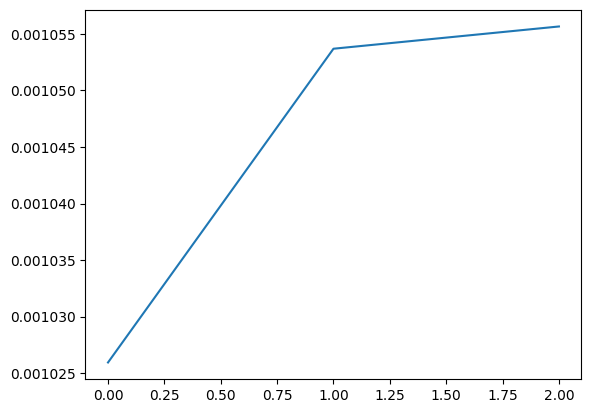

In [11]:
plt.plot(trainer.logs['Step'], trainer.logs['Train_tg_loss'])